## Попробуем TabNET, подбор гиперпараметров Optuna
- **помним про временные split, признаки и метрики те же**

## 1. Импорты

In [1]:
import os
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.metrics import Metric
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    precision_recall_curve, auc, average_precision_score, confusion_matrix
)
from sklearn.preprocessing import RobustScaler
import optuna
from optuna.samplers import TPESampler

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (8, 4)

RANDOM_STATE = 42
def set_seed(seed=RANDOM_STATE):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


## 2. Загрузка данных

In [2]:
def find_path_within_project(project_name, path_to_data):
    current_path = os.getcwd()
    while True:
        if project_name in os.listdir(current_path):
            return os.path.join(current_path, project_name, path_to_data)
        parent_path = os.path.dirname(current_path)
        if parent_path == current_path:
            raise FileNotFoundError(f"Проект '{project_name}' не найден")
        current_path = parent_path

full_path = find_path_within_project(
    "anomaly_detection_project",
    os.path.join("data", "raw", "creditcard_1_02_00.csv")
)

df = pd.read_csv(full_path)

print(f"\nРазмер данных: {df.shape[0]} строк, {df.shape[1]} столбцов")
print(f"Распределение классов:\n{df['Class'].value_counts(normalize=True)}")


Размер данных: 284807 строк, 35 столбцов
Распределение классов:
Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


## 3. Временные сплиты

In [3]:
time_col = 'Time_abs_hour'

def get_train_test(df, col, train_finish, train_start=0, test_finish=0, gap=0):
    if test_finish == 0:
        test_finish = df[col].max()
    test_start = train_finish + gap + 1
    df_train = df[(df[col] >= train_start) & (df[col] <= train_finish)]
    df_test = df[(df[col] >= test_start) & (df[col] <= test_finish)]
    print(f"train: {df_train[col].min()}–{df_train[col].max()} | test: {df_test[col].min()}–{df_test[col].max()}")
    return df_train, df_test

train_finish = df[time_col].max() - 8
df_train, df_test = get_train_test(df, time_col, train_finish)

train_finish_2 = df_train[time_col].max() - 8
df_train_2, df_val = get_train_test(df_train, time_col, train_finish_2)

train: 0.0–39.0 | test: 40.0–47.0
train: 0.0–31.0 | test: 32.0–39.0


## 4. Признаки , X, y ...

In [4]:
# признаки
unnecessary_cols = ['Time','Amount','Time_hour','Time_day','Amount_log', time_col]
target_col = 'Class'
drop_cols = [target_col] + unnecessary_cols

def xy(df):
    return df.drop(drop_cols, axis=1).values.astype('float32'), df[target_col].values

X_tr, y_tr = xy(df_train_2)
X_val, y_val = xy(df_val)
X_test, y_test = xy(df_test)
# полный трейн
X_train, y_train  = xy(df_train)

# # размерности
# n_features = X_tr.shape[1]
# print("n_features:", n_features)

# 5. Optuna — подбор гиперпараметров

In [5]:
# У TabNet отсутствует prauc , let's do it...
class PR_AUC_Metric(Metric):
    def __init__(self):
        self._name = "pr_auc"
        self._maximize = True  # Optuna будет максимизировать метрику

    def __call__(self, y_true, y_score):\
        # Если one-hot — берём индекс положительного класса
        if y_true.ndim > 1 and y_true.shape[1] == 2:
            y_true = np.argmax(y_true, axis=1)
        # Если y_score двумерный — берём вероятности положительного класса
        if y_score.ndim > 1 and y_score.shape[1] == 2:
            y_score = y_score[:, 1]
        return average_precision_score(y_true, y_score)

In [7]:
def objective(trial):
    params = dict(
        n_d=trial.suggest_int("n_d", 8, 64),
        n_a=trial.suggest_int("n_a", 8, 64),
        n_steps=trial.suggest_int("n_steps", 3, 6),
        gamma=trial.suggest_float("gamma", 1.0, 2.0),
        lambda_sparse=trial.suggest_float("lambda_sparse", 1e-6, 1e-2, log=True),
        seed=RANDOM_STATE,
        verbose=0
    )
    fit_params = dict(
        batch_size=trial.suggest_categorical("batch_size", [512, 1024, 2048]),
        virtual_batch_size=trial.suggest_categorical("virtual_batch_size", [128, 256])
    )
    lr = trial.suggest_float("lr", 1e-3, 1e-1, log=True)

    model = TabNetClassifier(
        **params,
        optimizer_fn=torch.optim.Adam,
        optimizer_params=dict(lr=lr),
        scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
        scheduler_params=dict(T_0=10, T_mult=1),
        device_name=device
    )
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric=[PR_AUC_Metric],
        max_epochs=50,
        patience=5,
        **fit_params
    )
    preds = model.predict_proba(X_val)[:, 1]
    # pr_auc = auc(*precision_recall_curve(y_val, preds)[1::-1])
    pr_auc = average_precision_score(y_val, preds)
    return pr_auc


set_seed()
study = optuna.create_study(direction="maximize", sampler=TPESampler(seed=RANDOM_STATE))


study.optimize(objective, n_trials=15, show_progress_bar=True)

print("Best trial:", study.best_trial.params)
print("Best PR-AUC:", study.best_value)

[I 2025-08-30 23:14:53,739] A new study created in memory with name: no-name-3425475e-c916-408f-bfd9-d07c8c70101b


  0%|          | 0/15 [00:00<?, ?it/s]


Early stopping occurred at epoch 9 with best_epoch = 4 and best_val_0_pr_auc = 0.24984
[I 2025-08-30 23:16:04,045] Trial 0 finished with value: 0.2498373475099866 and parameters: {'n_d': 29, 'n_a': 62, 'n_steps': 5, 'gamma': 1.5986584841970366, 'lambda_sparse': 4.2079886696066345e-06, 'batch_size': 2048, 'virtual_batch_size': 256, 'lr': 0.0010994335574766201}. Best is trial 0 with value: 0.2498373475099866.

Early stopping occurred at epoch 12 with best_epoch = 7 and best_val_0_pr_auc = 0.61776
[I 2025-08-30 23:17:24,994] Trial 1 finished with value: 0.6177586315353514 and parameters: {'n_d': 63, 'n_a': 55, 'n_steps': 3, 'gamma': 1.1818249672071006, 'lambda_sparse': 5.415244119402541e-06, 'batch_size': 1024, 'virtual_batch_size': 256, 'lr': 0.0019010245319870357}. Best is trial 1 with value: 0.6177586315353514.

Early stopping occurred at epoch 16 with best_epoch = 11 and best_val_0_pr_auc = 0.43113
[I 2025-08-30 23:20:09,216] Trial 2 finished with value: 0.4311325201876924 and parame

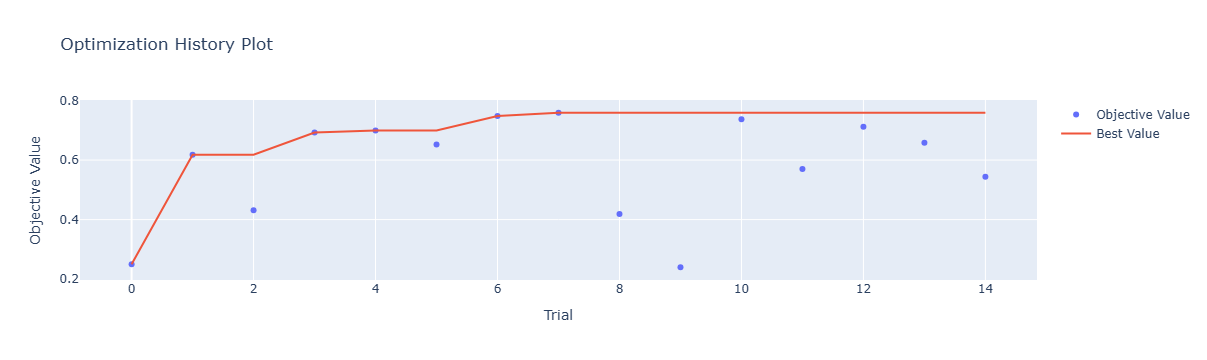

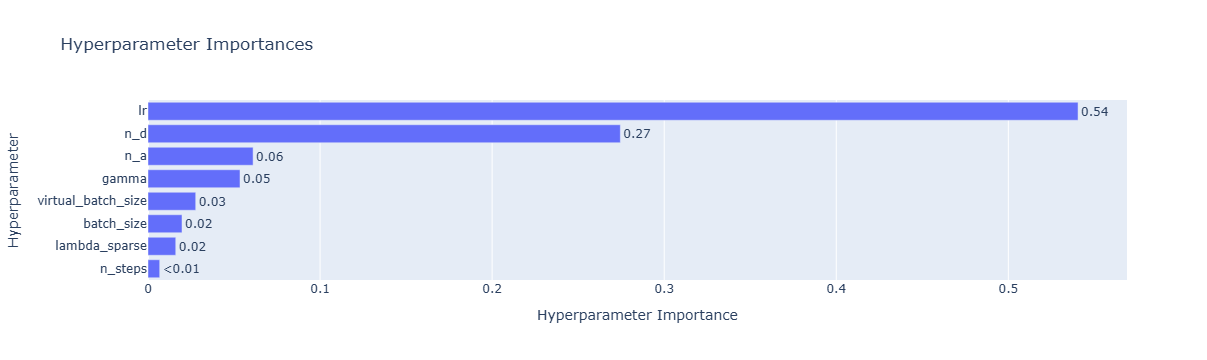

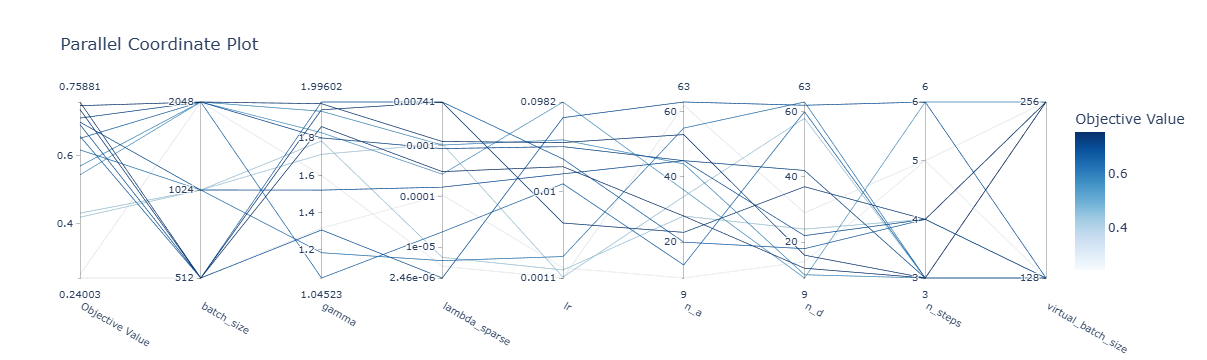

In [8]:
# optuna визуализация
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()

## 6. Обучение финальной модели

In [9]:
set_seed()
best_params = study.best_params
model_params = {k: best_params[k] for k in ["n_d", "n_a", "n_steps", "gamma", "lambda_sparse"]}
fit_params = {k: best_params[k] for k in ["batch_size", "virtual_batch_size"]}

final_model = TabNetClassifier(
    **model_params,
    seed=RANDOM_STATE,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=best_params["lr"]),
    scheduler_fn=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts,
    scheduler_params=dict(T_0=10, T_mult=1),
    device_name=device,
    verbose=0
)

final_model.fit(
    X_train, y_train,
    max_epochs=20,
    **fit_params
)

## 7. Оценка на тесте

In [10]:
y_score = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_score >= 0.5).astype(int)

pr_auc = auc(*precision_recall_curve(y_test, y_score)[1::-1])
roc_auc = roc_auc_score(y_test, y_score)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"PR-AUC={pr_auc:.4f} ROC-AUC={roc_auc:.4f} "
      f"Precision={precision:.3f} Recall={recall:.3f} F1={f1:.3f}")

PR-AUC=0.7921 ROC-AUC=0.9756 Precision=0.891 Recall=0.740 F1=0.809


##  8. Подбор порога по валидации

In [11]:
val_score = final_model.predict_proba(X_val)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_score)
f1_scores = 2 * prec * rec / (prec + rec + 1e-12)
best_thr = thr[np.nanargmax(f1_scores)]

print(f"Оптимальный порог по val: {best_thr:.3f}")

Оптимальный порог по val: 0.346


## 9. Финальные метрики и визуализация

In [12]:
y_pred_test = (y_score >= best_thr).astype(int)

precision = precision_score(y_test, y_pred_test)
recall = recall_score(y_test, y_pred_test)
f1 = f1_score(y_test, y_pred_test)

prec, rec, thr = precision_recall_curve(y_test, y_score)
pr_auc  = auc(rec, prec)

print("Test (порог подобран по валидации)  "
      f"PR-AUC={pr_auc:0.4f}  "
      f"Precision={precision:0.3f}  "
      f"Recall={recall:0.3f}, F1 = {f1:.3f}")

Test (порог подобран по валидации)  PR-AUC=0.7921  Precision=0.892  Recall=0.753, F1 = 0.817


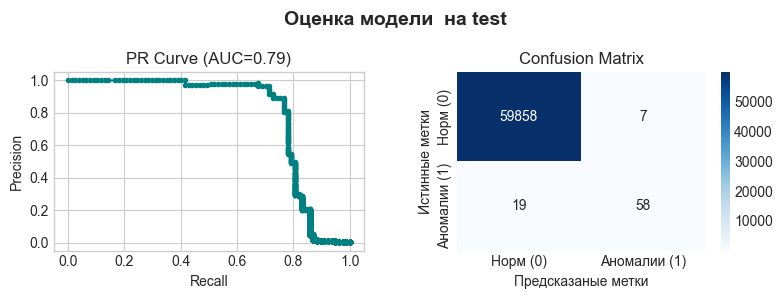


Precision=0.89,   Recall=0.75,   F1=0.82,   PR_AUC=0.79



In [13]:
# precision-recall кривая и confusion_matrix и метрики
# метрики печать и возвращаем f1, pr_auc
def print_metrics(y_true, y_pred,  pr_auc):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print('\n'+'='*60)
    print(f"Precision={precision:.2f},   Recall={recall:.2f},   F1={f1:.2f},   PR_AUC={pr_auc:.2f}")
    print('\n'+'='*60)
    # return f1, pr_auc


def plot_pr_and_cm(recalls, precisions, y_true, y_pred, main_label = ' на test',):
# # Создаём общую фигуру с 2 подграфиками (по горизонтали)
    fig, axs = plt.subplots(1, 2, figsize=(8, 3))
    # pr curve
    fig.suptitle("Оценка модели " + main_label, fontsize=14, fontweight='bold')


    labels = ['Норм (0)', 'Аномалии (1)']

    axs[0].plot(recalls, precisions, marker='.', color='teal')
    axs[0].set_xlabel("Recall")
    axs[0].set_ylabel("Precision")
    axs[0].set_title(f"PR Curve (AUC={pr_auc:.2f})")

    # cm
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axs[1])
    axs[1].set_xlabel("Предсказаные метки")
    axs[1].set_ylabel("Истинные метки")
    axs[1].set_title("Confusion Matrix")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3) # раздвигаем картинки
    plt.show()

    # 3) печать метрик
    print_metrics(y_true, y_pred,  pr_auc)
    pass

plot_pr_and_cm(recalls=rec, precisions=prec, y_true=y_test, y_pred= y_pred_test, main_label = ' на test',)

## 13. Выводы
**Датасет**
- **Объём**: 284 807 транзакций, 35 признаков.
- **Ну очень сильный дисбаланс**: 0,17% транзакций — мошеннические (Class == 1).

**Временное разбиение**: данные разделены по `Time_abs_hour`:
  - **Train**: 0–39 часов (224 865 строк).  
  - **Test**: 40–47 часов (59 942 строк).
  
**Модель**  
- **TabNet**
  
**Подбор гиперпараметров**
- **Optuna**
  
**Метрики**  | F1   | PR AUC |
- **Test**     | 0.82 | 0.79   |

**Вывод**
- Модель TabNET - высокое качество на тестовой выборке:
- - PR-AUC: 0.7921 — хороший результат для несбалансированных данных (аномалий всего 0.17%).
- -  Precision: 0.89, Recall: 0.75, F1: 0.82 — при оптимальном пороге 0.346, подобранном на валидации
- Подбор гиперпараметров через Optuna был эффективен.
- - Оптимизация позволила улучшить PR-AUC с ~0.7 до 0.79 на валидации и добиться устойчивой работы на тесте.
- Модель справилась с дисбалансом классов (0.17% аномалий)
  **Что можно улучшать:**
- Попробовать другие архитектуры .
- Добавить интерпретацию признаков если бы они были осмыслены , а не после PCA.

In [25]:
# 10. Сохранение модели

In [ ]:
#final_model.save_model("tabnet_creditcard")